# The Data Library for Python — Maximum Usage Reference Guide

## Introduction
The LSEG Data Library for Python provides a powerful and flexible interface for accessing snapshot, historical, and reference data through the LSEG Data Platform. While the library is designed for ease of use, it also enforces important usage limits, throttles, and request caps to ensure fair and compliant access across all users.

This article explains what these limits are, why they exist, how can you work with large datasets without hitting errors, what to do if you need a lot more data than the API allows

This guide is helpful for users who

 - Work with large instrument universes
 - Retrieve multi‑year history
 - Perform scheduled or high‑frequency extraction jobs
 - Need to avoid throttling, server timeouts, and HTTP 429 errors

All limits referenced here are sources from the official [Usage & Limit Guideline in the LSEG Data Library for Python documentation](https://developers.lseg.com/en/api-catalog/lseg-data-platform/lseg-data-library-for-python/documentation)

### 1) Global Usage Limits (Apply to All Requests)
#### Requests per Second

 - **Limit: ~5 requests per second**, aggregated across all applications sharing the same Workspace session.
 - **Recommendation:** Pace requests at 3–4 requests per second to avoid hitting throttle mechanisms.

#### Response Volume per Minute

 - **Limit: ~50 MB per minute** across the entire session.

#### Datapoints per Request

A “datapoint” = instrument × field × timestamp. For example, 50 instruments × 20 fields × 5 dates = 5,000 datapoints

From the official limits:

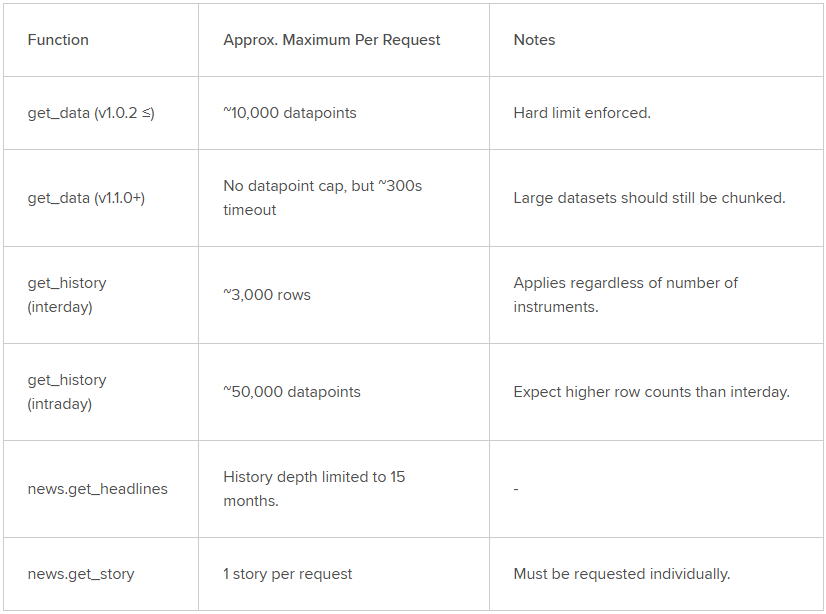

### 2) get_data
#### Limit Behavior

 - Older version of the library (lseg.data version 1.0.2 and below)
    - limited requests to **~10,000 datapoints.**
 - Newer version (lseg.data version 1.1.0 and above)
    - No strict limit, but **server timeouts ~300 seconds**, which means server stops working after 300 seconds if the request is too big.

**Safe Example** (good for beginners and testing)

In [6]:
import lseg.data as ld

ld.open_session()

# 3 instruments × 3 fields × 2 dates = 18 datapoints
df = ld.get_data(
    universe=['MSFT.O', 'AAPL.O', 'GOOG.O'], # 3 instruments
    fields=['BID', 'ASK', 'TRDPRC_1'], # 3 fields
    parameters={'SDate': '2025-12-27', 'EDate': '2025-12-28'} # 2 dates
)

display(df) # or print(df)

,Instrument,BID,ASK,TRDPRC_1
0,MSFT.O,401.14,401.2,401.17
1,AAPL.O,266.13,266.15,266.15
2,GOOG.O,304.4,304.42,304.4


### 3) get_history
**Interday History: Daily interval and above** (daily, 1d, 1D, 7D, 7d, weekly, 1W, monthly, 1M, quarterly, 3M, 6M, yearly, 1Y)

 - Cap: **~3,000 rows per request.**
 - **Daily bars:** ~251 trading days/year
   - -> **~11-12 years per requests**

In [8]:
interday_df = ld.get_history(
    universe='VOD.L',
    fields=['TRDPRC_1'],
    interval='1D',
    start='2015-01-01',
    end='2025-01-01'     # ~10 years, ≈ 2,520 rows
)
display(interday_df)

VOD.L,TRDPRC_1
Date,
2015-01-02,221.9
2015-01-05,218.703916
2015-01-06,216.405059
2015-01-07,216.8283
2015-01-08,220.412232
...,...
2024-12-23,66.72
2024-12-24,67.76
2024-12-27,67.52


**Intraday History: An hour interval and below** (tick, tas, taq, minute, 1min, 5min, 10min, 30min, 60min, hourly, 1h)

 - Cap: **~50,000 rows per request**
 - **1-minute bars:** ~390 minutes/trading day
   - -> limit to **~120-day windows**

In [23]:
from datetime import date, timedelta

ric = 'MSFT.O'

# 120-day window
start_date = date(2025, 12, 1)
end_date   = start_date + timedelta(days=120)

intraday_df = ld.get_history(
    universe=ric,
    fields=['TRDPRC_1', 'BID', 'ASK'],
    interval='1min',          # 1-minute interval
    start=str(start_date),
    end=str(end_date)
)

display(intraday_df)

MSFT.O,TRDPRC_1,BID,ASK
Timestamp,,,
2025-12-01 09:00:00,489.7,489.59,490.0
2025-12-01 09:01:00,489.5,489.02,489.84
2025-12-01 09:02:00,489.0,488.6,489.75
2025-12-01 09:03:00,488.69,488.48,489.5
2025-12-01 09:04:00,488.81,488.25,489.07
...,...,...,...
2026-02-17 23:55:00,396.1915,396.03,396.2
2026-02-17 23:56:00,396.18,396.1,396.2
2026-02-17 23:57:00,396.2,396.1,396.2


### 4) News Functions
#### news.get_headlines

 - 15-month depth only

In [28]:
# 15‑month range
end_date = date.today()
start_date = end_date - timedelta(days=450)  # ~15 months

headlines_df = ld.news.get_headlines(
    query='cheese',
    count=1000,
    start=start_date,
    end=end_date
)

display(headlines_df)

,headline,storyId,sourceCode
versionCreated,,,
2026-02-15 08:38:57.841,"Largest collection of milk so far, more acidif...",urn:newsml:newsroom:20260215:nNRAzi2b5a:0,NS:EURUNI
2026-02-14 21:44:10.885,Weekly protein digest: US–China trade truce co...,urn:link:webnews:20260214:nNRAzhz8dy:0,NS:POUSIT
2026-02-14 18:11:45.608,Panic in Russian supermarkets due to crazy prices,urn:newsml:newsroom:20260214:nNRAzhy3nw:0,NS:NOTENG
2026-02-13 19:21:27.000,Agricultural Marketing Service - Dairy Market ...,urn:newsml:reuters.com:20260213:nNDL1G2J7J:1,NS:PUBT
2026-02-13 13:21:07.973,Bizcommunity.com· 1d January sees fifth consec...,urn:link:webnews:20260213:nNRAzhgdca:0,NS:MSNSOU
...,...,...,...
2024-11-29 03:42:16.490,"November 25, 2024: University of Wisconsin-Mad...",urn:newsml:newsroom:20241129:nNRAum72k9:0,NS:NEWBIH
2024-11-28 00:00:00.000,Cheese Market to grow by USD 38.8 billion from...,urn:newsml:newsroom:20241209:nNRAur01sv:0,NS:PLUCOM
2024-11-27 19:38:29.730,Russia's EkoNiva ups milk production 8% in 9M ...,urn:newsml:reuters.com:20241127:nIFX3zpWPa:1,NS:IFX


#### news.get_story

 - 1 story per request
 - Best retrieved by looping over story IDs with throttling.

In [36]:
from IPython.display import HTML
import time

headlines_df = ld.news.get_headlines(
    query='cheese',
    count=10
)

stories = []
story_ids = headlines_df['storyId'].dropna().tolist()

for story_id in story_ids:
    try:
        story = ld.news.get_story(story_id)
        stories.append(story)
    except Exception as e:
        print(f'Error for story {sid}: {e}')

    time.sleep(0.3)  # throttle: ~3 req/sec (safe)

print('Total stories retrieved:', len(stories))

print('Print first news story: ')
HTML(stories[0])

Total stories retrieved: 10
Print first news story: 


In [37]:
#close sessions - best practices
ld.close_session()

### 5) How to Handle Errors (429, 503)
When limits are exceeded, the system will return:

 - **429 Too Many Requests**
 - **503 Service Unavailable**
You should follow this article to adjust your Python code and run it again. However, if daily limit is reached, you'll need to wait until midnight (your local time) for it to be reset.

To check your usage limits remaining, please check article [Check LSEG Data Library for Python Usage Limits Remaining | Devportal](https://developers.lseg.com/en/article-catalog/article/check-lseg-data-library-for-python-usage-limits-remaining)

### 6) Tips for Safe High‑Volume Retrieval
 - Throttle to ≤ 3–4 requests/sec
 - Break requests into predictable windows
 - Store data locally (Parquet/CSV) to avoid repeat downloads
 - For multi‑million‑row workloads, use **Tick History** or other product instead, contact your LSEG representative regarding this
    - These products are purpose‑built for high‑volume extraction.
    - The Data Library is ideal for flexible programmatic access, not large‑scale data lake extraction.

## Conclusion

The LSEG Data Library for Python offers a powerful and consistent way to access the LSEG Data Platform, but understanding usage limits is essential to avoid throttling, maintain performance, and ensure compliance. By correctly sizing requests, respecting rate limits, and using pagination and batching, you can build robust workflows for high-volume data retrieval.

For extremely large workloads- such as multi‑million‑row historical extracts - consider LSEG’s Tick History or other products, which are optimized for large-scale extractions.

If you need help choosing the right API for your workload, your LSEG account representative is available to assist, or you can go to [MyAccount](https://myaccount.lseg.com/en/signin) > LSEG Support > Product: Raise a case.